In [1]:
import tushare as ts
import pandas as pd
from datetime import datetime 
pro = ts.pro_api()
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

balance_kv={
    "inventories":"存货",
}

def getbalance_yearly(ts_code='002624.sz',priod=5):
    df_all=pd.DataFrame()
    for i in range(0,priod+1):
        year=datetime.now().year-i
        key='Y'+str(year)
        df = pro.balancesheet(ts_code='002624.sz',fields=",".join(balance_kv.keys()),period=str(year)+'1231')
        
        if(df.empty):
            continue
            
        df = df.stack()
        df=pd.DataFrame(df[0])
        df['v']=df[0]
        df.columns=["key",key]
        df['key']=df.index
        df['key']=df.apply(lambda x:balance_kv[x.key] if x.key in balance_kv else x.key ,axis = 1)
        df[key]=df.apply(lambda x:str(round(int(x[key])/100000000,2))+"亿" if isinstance(x[key],float) else x[key],axis = 1)
    
        if df_all.empty:
            df_all=df
        else:
            df_all['Y'+str(year)]=df['Y'+str(year)]
        
    return df_all

df=getbalance_yearly(ts_code='002624.sz',priod=6)

def markblod(x):
    blod_key=[]     
    return 'color : red;font-weight:700' if x in blod_key else ''

df=df.style.applymap(markblod).set_caption('<h3>完美世界(002624.sz)-资产负债表</h3>').hide()
df

key,Y2020,Y2019,Y2018,Y2017,Y2016
存货,10.27亿,17.6亿,21.42亿,15.76亿,4.96亿


In [2]:
import pandas as pd
import tushare as ts
from xlib.mysql import mysql
from xlib.astock import AStock

def fcompute(ts_code,df_cal,basic):
    df_price=AStock.getStockDailyPriceByCode(ts_code,db)
    df_price=pd.merge(df_cal,df_price,on=['trade_date'],how='outer', validate="one_to_many")
    df_balance=mysql.selectToDf("select ann_date as trade_date,inventories from astock_finance_balancesheet where ts_code='"+ts_code+"' and report_type=1 order by trade_date asc",db)
    df_daily_basic=mysql.selectToDf("select trade_date,total_mv from astock_price_daily_basic where ts_code='"+ts_code+"' order by trade_date asc",db)
    df=pd.merge(df_price, df_balance, how='left', on='trade_date', copy=True, indicator=False)
    df=pd.merge(df, df_daily_basic, how='left', on='trade_date', copy=True, indicator=False)
    df=df.fillna(method='ffill')
    df['ts_code']=ts_code
    df['industy']=str(basic[basic['ts_code']==ts_code]['industry'].values[0])
    df=df[df.trade_date>'20150101']
    df=df[df.trade_date<'20220410']
    df=df.reset_index(drop=True)
    df['f1']=df['inventories'].astype('float')/df['total_mv'].astype('float')
    df.rename(columns={'ts_code':'symbol','trade_date':'date'}, inplace = True)
    df['date']=df['date'].map(lambda x: x[:4]+'-'+x[4:6]+'-'+x[6:8])
    return df


db="tushare"
df_cal=mysql.selectToDf("select cal_date as trade_date from astock_trade_cal where is_open=1",db)
basic=mysql.selectToDf("select ts_code,industry from astock_basic",db)

pro = ts.pro_api()
df_code = pro.index_weight(index_code='000300.SH', start_date='20150101', end_date='20220410')
df_code.drop_duplicates(subset=['con_code'],keep='first',inplace=True)
 
df_all=[]
df_mean_all=[]
df_code=df_code['con_code'].to_list()

for ts_code in df_code:
    df=fcompute(ts_code,df_cal,basic)
    df_all.append(df)
    df_mean_all.append({
        'ts_code':ts_code,
        'industry':df['industry'].values[0],
        'mean':df['f1'].mean()
    })
    print(ts_code)

df_all=pd.concat(df_all)


df_mean_all=pd.DataFrame(df_mean_all)
df_all['f2']=df_all.apply(lambda x: df_mean_all[df_mean_all['industry']==x['industry']]['mean'].mean(),axis=1) 
df_all['f3']=df_all['f1']/df_all['f2']
    
print(df_all)
df_all.to_csv("./xlib/cache/fin.csv")

603195.SH
003816.SZ
300782.SZ
601138.SH
600989.SH
601698.SH
300750.SZ
601916.SH
002938.SZ
601319.SH
603259.SH
601236.SH
300896.SZ
601865.SH
601066.SH
300759.SZ
300760.SZ
688111.SH
601990.SH
603486.SH
002916.SZ
603392.SH
600025.SH
603659.SH
603087.SH
300677.SZ
603882.SH
603260.SH
001979.SZ
300676.SZ
603233.SH
601155.SH
300628.SZ
601108.SH
300498.SZ
300595.SZ
300601.SZ
603501.SH
002841.SZ
603833.SH
603517.SH
601881.SH
300408.SZ
300413.SZ
300558.SZ
300450.SZ
603019.SH
603658.SH
002812.SZ
603939.SH
603338.SH
601966.SH
603799.SH
300433.SZ
002821.SZ
603160.SH
603986.SH
601985.SH
300529.SZ
002791.SZ
601021.SH
603369.SH
603899.SH
000333.SZ
601808.SH
601939.SH
002179.SZ
601169.SH
603806.SH
002714.SZ
002709.SZ
601238.SH
603288.SH
603993.SH
300347.SZ
300316.SZ
601231.SH
601360.SH
002157.SZ
601800.SH
601225.SH
601100.SH
300274.SZ
601669.SH
002624.SZ
002602.SZ
002607.SZ
002600.SZ
002601.SZ
002594.SZ
002568.SZ
601216.SH
002555.SZ
601799.SH
601933.SH
601211.SH
002736.SZ
000166.SZ
300144.SZ
600919.SH


Starting training...
[1]	valid_0's l2: 0.128037
Training until validation scores don't improve for 5 rounds
[2]	valid_0's l2: 0.0911203
[3]	valid_0's l2: 0.0674176
[4]	valid_0's l2: 0.05194
[5]	valid_0's l2: 0.0420785
[6]	valid_0's l2: 0.0356345
[7]	valid_0's l2: 0.0314069
[8]	valid_0's l2: 0.0287121
[9]	valid_0's l2: 0.026836
[10]	valid_0's l2: 0.025674
[11]	valid_0's l2: 0.0248322
[12]	valid_0's l2: 0.0243003
[13]	valid_0's l2: 0.0238569
[14]	valid_0's l2: 0.023644
[15]	valid_0's l2: 0.0234011
[16]	valid_0's l2: 0.0232955
[17]	valid_0's l2: 0.0232486
[18]	valid_0's l2: 0.0231655
[19]	valid_0's l2: 0.0231292
[20]	valid_0's l2: 0.0231073
[21]	valid_0's l2: 0.023086
[22]	valid_0's l2: 0.023101
[23]	valid_0's l2: 0.0231081
[24]	valid_0's l2: 0.0231264
[25]	valid_0's l2: 0.0231462
[26]	valid_0's l2: 0.0231562
Early stopping, best iteration is:
[21]	valid_0's l2: 0.023086
Saving model...
loading datas...
runing backtest...


                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2018-01-02  2018-01-02
End Period                 2022-04-08  2022-04-08
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          304.29%     -2.82%
CAGR﹪                     38.75%      -0.67%

Sharpe                     1.67        0.07
Smart Sharpe               1.66        0.07
Sortino                    2.69        0.11
Smart Sortino              2.66        0.1
Sortino/√2                 1.9         0.07
Smart Sortino/√2           1.88        0.07
Omega                      1.36        1.36

Max Drawdown               -15.59%     -48.95%
Longest DD Days            133         1190
Volatility (ann.)          21.75%      20.98%
R^2                        0.27        0.27
Calmar                     2.49        -0.01
Skew                       0.27        0.51
Kurtosis                   3.78        

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-02-24,2020-03-23,2020-07-06,133,-15.585366,-14.372164
2,2019-03-26,2019-05-06,2019-06-27,93,-14.599130,-13.938015
3,2018-09-27,2018-10-18,2018-11-19,53,-13.369400,-11.495617
4,2018-04-27,2018-07-05,2018-08-24,119,-12.619467,-12.443386
5,2022-02-11,2022-03-15,2022-04-08,56,-11.634728,-9.243267


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


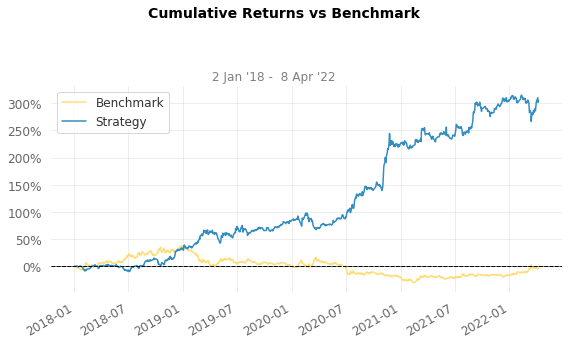

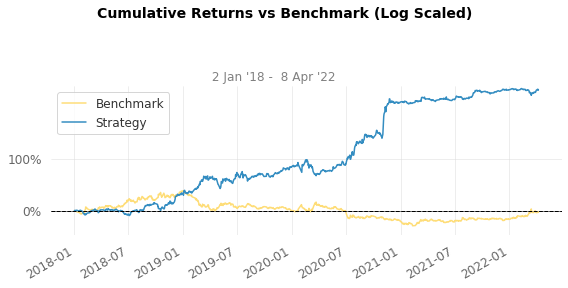

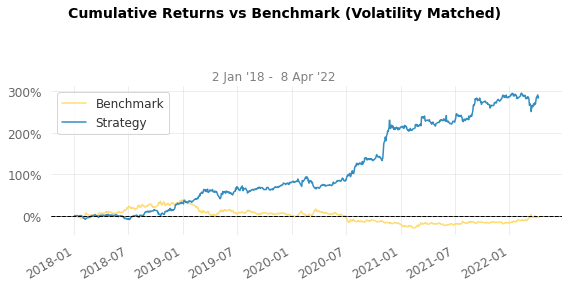

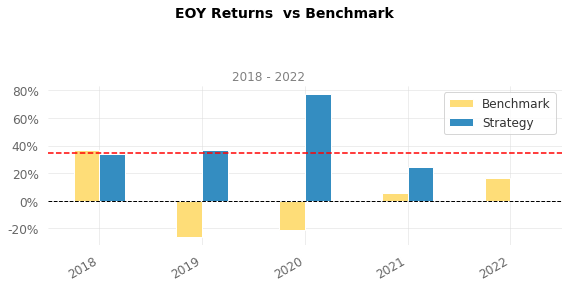

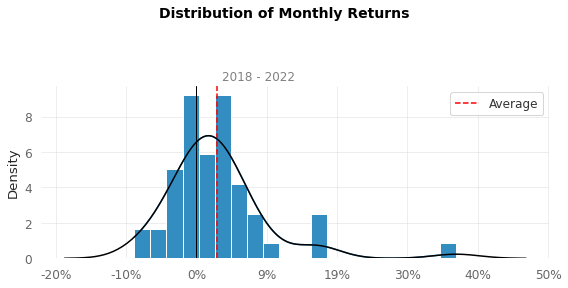

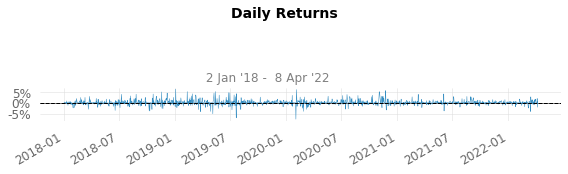

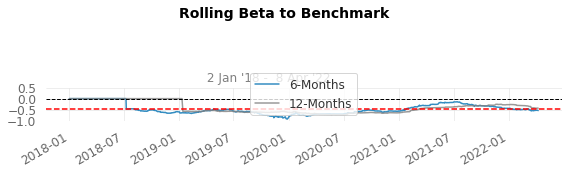

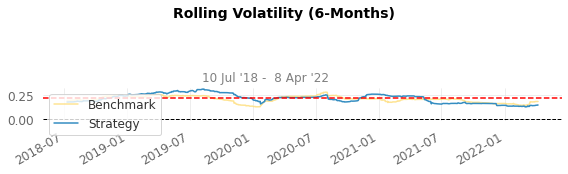

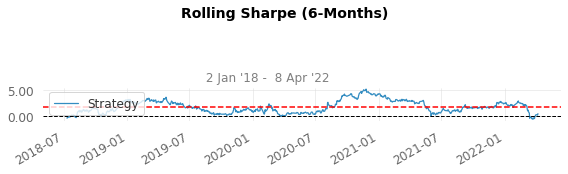

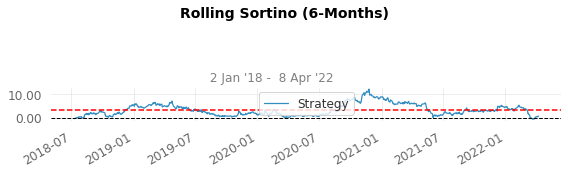

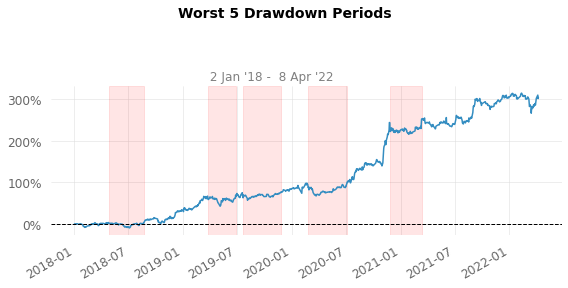

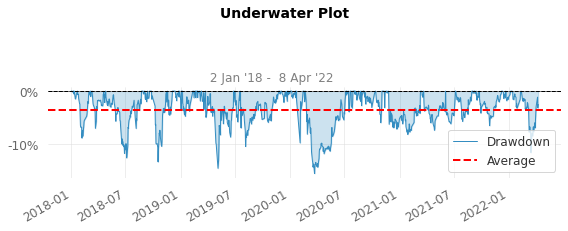

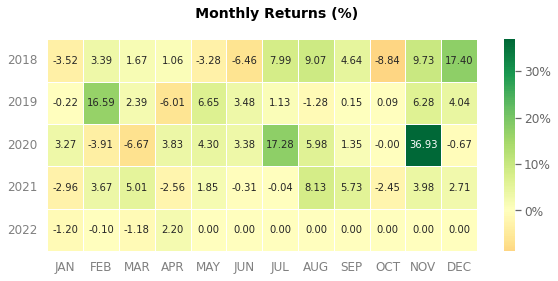

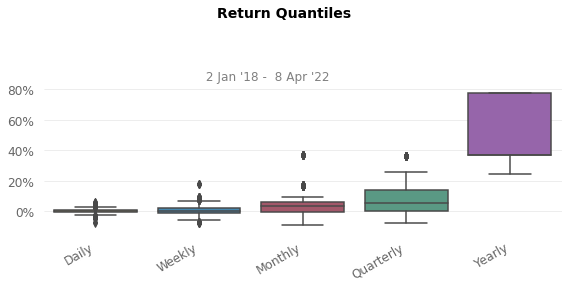

In [1]:
import pandas as pd
from xlib import data
import akshare as ak

idx_data = ak.index_zh_a_hist(symbol='000300', period="daily", start_date='20180101', end_date='20220410')    
idx_data.rename(columns={'日期':'date', '开盘':'open', '收盘':'close', 
                           '最高':'high', '最低':'low', '成交量':'volume',
                           '成交额':'amount', '振幅':'swing', '涨跌幅':'chg_pct',
                           '涨跌额':'chg_amount', '换手率':'turnover',
                          }, inplace = True)
idx_data['date'] = pd.to_datetime(idx_data['date'], format='%Y-%m-%d')
bench=idx_data.set_index('date')

df=pd.DataFrame()
df=pd.read_csv('./xlib/cache/fin.csv',index_col=0)
df=df.reset_index(drop=True)
df['label']=df['close'].shift(-30)/df['close']


df['industry']=pd.factorize(df["industry"])[0].astype(int)

from xlib import model
df_train,df_valid,df_pred=model.datasplit(df,train_end='2017-01-01',valid_end='2018-01-01')
model.lgbtrain(df_train,df_valid,label='label')  
preds=model.lgbpred(df_pred,label='label') 

from xlib.strategies import Top10Strategy
from xlib import backtest
preds['score']=preds.apply(lambda x: -9 if x['high']==x['low'] else x['pred'] ,axis=1)
preds['rank']=preds.groupby('date')['score'].rank(method='max',ascending=False)
preds['signal']=preds.apply(lambda x: 1 if x['rank']<=10 else 0 ,axis=1)



returns=backtest.test(preds,Top10Strategy,hold_day=30)

preds=preds[preds.signal==1]
preds.to_csv("./xlib/cache/preds29.csv")

backtest.analysis(returns,bench)